In [8]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

# Generate initial state

We use the code created by the ion trapping group to compute the equilibrium positions of ions in the Penning trap. First we import the `mode_analysis_code` module:

In [2]:
import mode_analysis_code

Then we create a `ModeAnalsysis` object. This object is central to all sorts of calculations. The parameter $N$ is the number of ions. The tuple `Vtrap` specifies the voltages on the trap electrodes. The parameter `Vwall` is the voltage on the rotating wall electrodes. And finally the parameter `frot` is the frequency of the rotating wall potential in ${\rm kHz}$. We will discuss the various voltages in more detail later on.

In [3]:
mode_analysis = mode_analysis_code.ModeAnalysis(N=127,
                                                Vtrap=(0.0, -1750.0, -2000.0),
                                                Vwall=5.0,
                                                frot=180.0)
mode_analysis_has_run = False

A complete mode analysis is executed via the run command. Note that this can be a rather lengthy computation (several minutes long) depending on the number of ions. Therefore we take precautions to not run the mode analysis a second time after it has already run. If you'd like to run the mode analysis a second time you need to set the variable `mode_analysis_has_run` to True.

In [7]:
if not mode_analysis_has_run:
    mode_analysis.run()
    mode_analysis_has_run = True

## Equilibrium positions of ions

The `ModeAnalysis.run()` call finds the equilibrium positions of the ions in the trap among other things. We can create a top view of the ion crystal by plotting the $x$ and $y$ coordinates of the ions:

<IPython.core.display.Javascript object>


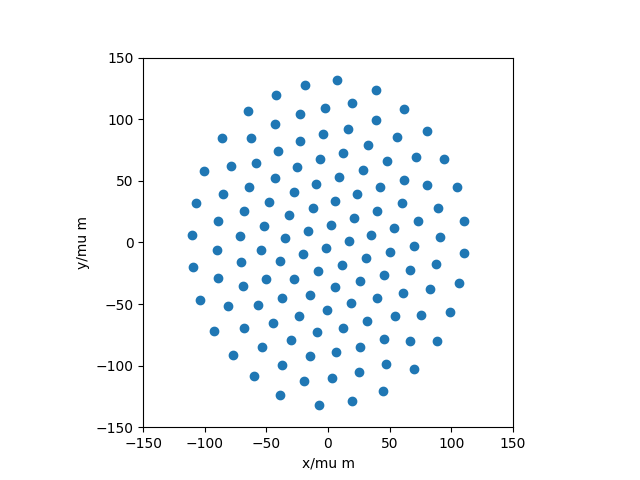

In [11]:
plt.figure()
plt.plot(1.0e6 * mode_analysis.uE[:mode_analysis.Nion], 1.0e6 * mode_analysis.uE[mode_analysis.Nion:], 'o');
plt.xlabel('x/mu m')
plt.ylabel('y/mu m')
rmax = 150.0
for l in [plt.xlim, plt.ylim]:
    l([-rmax, rmax])
plt.gca().set_aspect(1)

## Axial energy eigenvalues

The `ModeAnalyis` class also computes the axial eigenfrequencies of the ion crystal. There is a built-in method to visualize the eigenfrequencies:

<IPython.core.display.Javascript object>


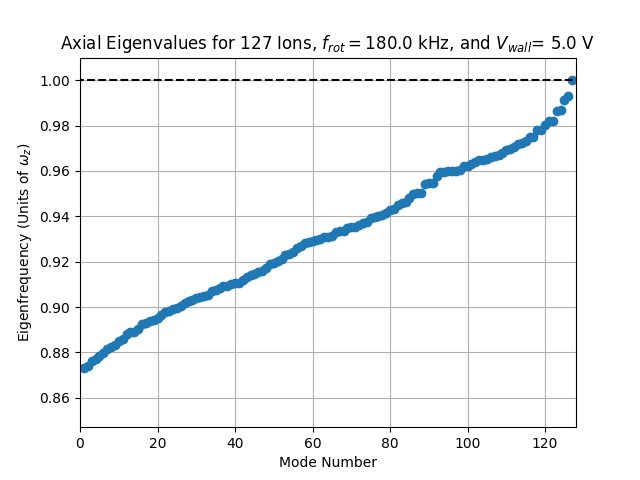

In [9]:
mode_analysis.show_axial_Evals();

# Units

Most calcualtions are done in a dimensionless system of units. Conversion to dimensionless and experimental form are done with the following two methods:

```
    def dimensionless(self):
        """Calculate characteristic quantities and convert to a dimensionless
        system
        """
        # characteristic length
        self.l0 = ((self.k_e * self.q ** 2) / (.5 * self.m_Be * self.wz ** 2)) ** (1 / 3)
        self.t0 = 1 / self.wz  # characteristic time
        self.v0 = self.l0 / self.t0  # characteristic velocity
        self.E0 = 0.5*self.m_Be*(self.wz**2)*self.l0**2 # characteristic energy
        self.wr = self.wrot / self.wz  # dimensionless rotation
        self.wc = self.wcyc / self.wz  # dimensionless cyclotron
        self.md = self.m / self.m_Be  # dimensionless mass

    def expUnits(self):
        """Convert dimensionless outputs to experimental units"""
        self.u0E = self.l0 * self.u0  # Seed lattice
        self.uE = self.l0 * self.u  # Equilibrium positions
        self.axialEvalsE = self.wz * self.axialEvals
        self.planarEvalsE = self.wz * self.planarEvals
        # eigenvectors are dimensionless anyway
```

Apparently the characteristic length is
$
l_0 = \left(\frac{q^2}{4\pi\epsilon_0}/(m \omega_z^2/2)\right)^{1/3}
$
Not quite sure what the meaning of this length scale is.


## Trap potential

The `ModeAnalysis.__init__()` method takes a parameter `Vtrap` that specifies the electrostatic potentials as far as I can tell. A comment in the source code suggests that the three components of this vector are the voltages on the end, middle, and center trap electrodes. Presumably these are in Volts. Inside `__init__()` we then calculate 0th, first, second, and fourth order moments of the trap potential at the center of the trap from the voltages. These are compute using a 4x3 matrix that is explained in "Teale's final paper". The result is stored in `self.Coeff`. The axial trap frequency is computed from this as follows:
$$
\omega_z=\sqrt{2 q {\tt self.Coeff[2]} / m}
$$
So this suggests that `self.Coeff[2]` corresponds to what I've been calling $k_z$.

A "wall potential" of $V_{\rm wall}=5$ is translated into a coefficient ${\tt self.Cw2} = q V_{\rm wall} 1612$. Apparently this is not used anymore. Instead, we use the parameter ${\tt self.Cw} = 1612 V_{\rm wall} / V_0$ where $V_0 = 1/2 m \omega_z^2 / q$ which really reduces to ${\tt self.Coeff[2]}$. I think this make `self.Cw` equivalent with the parameter $\delta$ I've been using up to perhaps a factor of 2 which I need to check on. The stronger axis of the trap is along $x$, the weaker axis is along $y$.

Apparently we are using a trap rotation frequency of $180 {\rm kHz}$ by default.

The default axial magnetic field is $B_z=4.4588T$.

# Parameters for dynamic ion simulations

In [13]:
print(mode_analysis.Cw)
print(mode_analysis.wrot)
print(mode_analysis.Coeff)
print(mode_analysis.wz)
print(mode_analysis.m_Be)
print(mode_analysis.q)
print(mode_analysis.B)
print(2.0 * np.pi / mode_analysis.wcyc)

0.00168764886016
1130973.3552923256
[ -1.71987500e+03  -1.25000000e+00   4.77587500e+06   1.89000000e+08]
10112373.2322
1.496535906374e-26
1.602176565e-19
4.4588
1.3162507819470977e-07


# Simulation

In [14]:
import coldatoms

 ## Building the ensemble
 
 First we need to construct the initial state of the ions.

In [139]:
def create_ensemble(uE, omega_z, mass, charge):
    num_ions = int(uE.size / 2)
    x = uE[:num_ions]
    y = uE[num_ions:]
    r = np.sqrt(x**2 + y**2)
    r_hat = np.transpose(np.array([x / r, y / r]))
    phi_hat = np.transpose(np.array([-y / r, x / r]))
    v = np.zeros([num_ions, 2], dtype=np.float64)
    for i in range(num_ions):
        v[i, 0] = omega_z * r[i] * phi_hat[i, 0]
        v[i, 1] = omega_z * r[i] * phi_hat[i, 1]
    
    ensemble = coldatoms.Ensemble(num_ions)
    for i in range(num_ions):
        ensemble.x[i, 0] = x[i]
        ensemble.x[i, 1] = y[i]
        ensemble.x[i, 2] = 0.0
        ensemble.v[i, 0] = v[i, 0]
        ensemble.v[i, 1] = v[i, 1]
        ensemble.v[i, 2] = 0.0
    
    ensemble.ensemble_properties['mass'] = mass
    ensemble.ensemble_properties['charge'] = charge
    
    return ensemble

## Forces

In [140]:
coulomb_force = coldatoms.CoulombForce()

In [174]:
class TrapPotential(object):

    def __init__(self, kz, delta, omega, phi_0):
        self.kz = kz
        self.kx = -(0.5 + delta) * kz
        self.ky = -(0.5 - delta) * kz
        self.phi_0 = phi_0
        self.phi = phi_0
        self.omega = omega

    def reset_phase(self):
        self.phi = self.phi_0
            
    def force(self, dt, ensemble, f):
        self.phi += self.omega * 0.5 * dt
        
        q = ensemble.ensemble_properties['charge']
        if q is None:
            q = ensemble.particle_properties['charge']
            if q is None:
                raise RuntimeError('Must provide ensemble or per particle charge')

        cphi = np.cos(self.phi)
        sphi = np.sin(self.phi)
        kx = self.kx
        ky = self.ky
        
        x = ensemble.x[:, 0]
        y = ensemble.x[:, 1]
        z = ensemble.x[:, 2]
        
        f[:, 0] += dt * q * (
            (-kx * cphi * cphi - ky * sphi * sphi) * x + cphi * sphi * (ky - kx) * y)
        f[:, 1] += dt * q * (
            cphi * sphi * (ky - kx) * x + (-kx * sphi * sphi - ky * cphi * cphi) * y)
        f[:, 2] += -dt * q *self.kz * z

        self.phi += self.omega * 0.5 * dt

In [175]:
trap_potential = TrapPotential(mode_analysis.Coeff[2], mode_analysis.Cw, mode_analysis.wrot, np.pi / 2.0)

In [176]:
def evolve_ensemble(dt, t_max, ensemble, Bz, forces):
    num_steps = int(t_max / dt)
    coldatoms.bend_kick(dt, Bz, ensemble, forces, num_steps=num_steps)
    coldatoms.bend_kick(t_max - num_steps * dt, Bz, ensemble, forces)

<IPython.core.display.Javascript object>


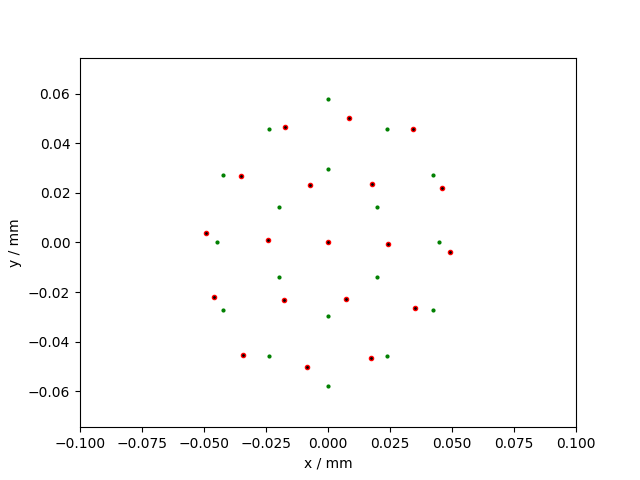

In [182]:
my_ensemble = create_ensemble(mode_analysis.uE,
                              mode_analysis.wrot,
                              mode_analysis.m_Be,
                              mode_analysis.q)
x_0 = np.copy(my_ensemble.x[:, 0])
y_0 = np.copy(my_ensemble.x[:, 1])

trap_potential.phi = np.pi / 2.0

alpha = 5.0 * 2.0 * np.pi

evolve_ensemble(1.0e-9, alpha / mode_analysis.wrot, my_ensemble, mode_analysis.B, [coulomb_force, trap_potential])

plt.figure()
plt.plot(1.0e3 * x_0, 1.0e3 * y_0, 'go', ms=2)
plt.plot(1.0e3 * my_ensemble.x[:,0], 1.0e3 * my_ensemble.x[:,1], 'ro', ms=3)
alpha = alpha
plt.plot(1.0e3 * (np.cos(-alpha) * my_ensemble.x[:, 0] - np.sin(-alpha) * my_ensemble.x[:, 1]),
         1.0e3 * (np.sin(-alpha) * my_ensemble.x[:, 0] + np.cos(-alpha) * my_ensemble.x[:, 1]), 'ko', ms=1)
plt.xlabel('x / mm')
plt.ylabel('y / mm')
x_max = 0.1e0
y_max = x_max
plt.xlim([-x_max, x_max])
plt.ylim([-y_max, y_max])
plt.axes().set_aspect('equal', 'datalim')

# Serialization and deserialization of ensembles

In [27]:
def ensemble_to_json(ensemble):
    serialized = {}
    serialized['x'] = json.dumps(ensemble.x.tolist())
    serialized['v'] = json.dumps(ensemble.v.tolist())
    serialized['ensemble_properties'] = json.dumps(ensemble.ensemble_properties)
    particle_properties = {}
    for prop,val in ensemble.particle_properties.items():
        particle_properties[prop] = json.dumps(val.tolist())
    serialized['particle_properties'] = particle_properties
    return json.dumps(serialized)

In [28]:
ensemble_to_json(my_ensemble)

'{"ensemble_properties": "{\\"mass\\": 1.496535906374e-26, \\"charge\\": 1.602176565e-19}", "v": "[[-1.547804030870488, 1.0562995026321829, 0.0], [6.043957570676456, -28.918979641544073, 0.0], [-6.000590735696467, -5.924871616822663, 0.0], [-9.757318315375931, 1.5767026916276423, 0.0], [-17.955369926242444, 16.864734171299666, 0.0], [-5.314217227665005, 8.322926272241451, 0.0], [3.186554889361839, 7.8289763437168665, 0.0], [-26.72354655624583, 2.862775680105289, 0.0], [-2.451446556189831, -28.493751230785133, 0.0], [-11.191520204258726, -28.36841869792929, 0.0], [-22.192045897932495, -4.877087635439653, 0.0], [-14.023067676758288, -5.422205122810512, 0.0], [-4.238778650459407, 45.859591285527266, 0.0], [13.41699995104401, -14.169725175414568, 0.0], [-17.527985785059684, 31.261539997040394, 0.0], [32.31759032372386, 37.80150031835611, 0.0], [17.41073940075334, 13.4752191491209, 0.0], [32.067300296305845, -2.4800980873799916, 0.0], [10.789522764478349, -36.343509945330254, 0.0], [22.0034

In [29]:
def json_to_ensemble(s):
    d = json.loads(s)
    x = np.array(ast.literal_eval(d['x']))
    v = np.array(ast.literal_eval(d['v']))
    ensemble_properties = d['ensemble_properties']
    particle_properties = {}
    for key, val in d['particle_properties']:
        particle_properties[key] = np.array(ast.literal_eval(val))
    num_ptcls = x.shape[0]
    ensemble = coldatoms.Ensemble(num_ptcls)
    ensemble.x = x
    ensemble.v = v
    ensemble.ensemble_properties = ensemble_properties
    ensemble.particle_properties = particle_properties
    return ensemble

In [30]:
round_trip = json_to_ensemble(ensemble_to_json(my_ensemble))

In [31]:
my_ensemble = create_ensemble(mode_analysis.uE,
                              mode_analysis.wrot,
                              mode_analysis.m_Be,
                              mode_analysis.q)
with open("ensemble.txt", "w") as text_file:
    text_file.write(ensemble_to_json(my_ensemble))

In [32]:
s=''
with open('ensemble.txt', 'r') as text_file:
    s=text_file.read()

# Axial spectra

In order to study the axial spectra we need to excite the axial modes. To do this we use laser cooling beams. In addition to cooling, these beams also induce recoil heating.

In [183]:
class DopplerDetuning(object):
    def __init__(self, Delta0, k):
        self.Delta0 = Delta0
        self.k = np.copy(k)
        
    def detunings(self, x, v):
        return self.Delta0 - np.inner(self.k, v)

In [184]:
class GaussianBeam(object):
    """A laser beam with a Gaussian intensity profile."""
    
    def __init__(self, S0, x0, k, sigma):
        """Construct a Gaussian laser beam from position, direction, and width.
        
        S0 -- Peak intensity (in units of the saturation intensity).
        x0 -- A location on the center of the beam.
        k -- Propagation direction of the beam (need not be normalized).
        sigma -- 1/e width of the beam."""
        self.S0 = S0
        self.x0 = np.copy(x0)
        self.k_hat = k / np.linalg.norm(k)
        self.sigma = sigma
        
    def intensities(self, x):
        xp = x - self.x0
        xperp = xp - np.outer(xp.dot(self.k_hat[:, np.newaxis]), self.k_hat)
        return self.S0 * np.exp(-np.linalg.norm(xperp, axis=1)**2/self.sigma)

In [185]:
class UniformIntensity(object):
    """Uniform intensity profile."""
    
    def __init__(self, S0):
        self.S0 = S0
        
    def intensities(self, x):
        num_ptcls = x.shape[0]
        return np.full(num_ptcls, self.S0)

In [186]:
wavelength = 780.0e-9
k = 2.0 * np.pi / wavelength
gamma = 2.0 * np.pi * 6.1e6
hbar = 1.0e-34
sigma = 1.0e-3

cooling_beams = [
    coldatoms.RadiationPressure(gamma, hbar * kp,
                      UniformIntensity(S0=0.1),
                      DopplerDetuning(-0.5 * gamma, kp)) for kp in [
        np.array([0.0, 0.0, k]),
        np.array([0.0, 0.0, -k]),
    ]]

In [187]:
import time

In [188]:
my_ensemble = create_ensemble(mode_analysis.uE,
                              mode_analysis.wrot,
                              mode_analysis.m_Be,
                              mode_analysis.q)

trap_potential.phi = np.pi / 2.0

t_max = 1.0e-3
dt = 5.0e-9
num_steps = np.ceil(t_max / dt)

t_start = time.clock()
evolve_ensemble(dt, t_max,
                my_ensemble, mode_analysis.B, [coulomb_force, trap_potential] + cooling_beams)
t_end = time.clock()
delta_t = t_end - t_start
print("delta_t == ", delta_t)
print("num_steps == ", num_steps)
print("delta_t / num_steps == ", delta_t / num_steps)

plt.figure()
plt.plot(1.0e3 * my_ensemble.x[:,0], my_ensemble.v[:,2], 'ro', ms=3)
plt.xlabel('x / mm')
plt.ylabel(r'$v_z / (m/s)$')

#x_max = 0.5e0
#y_max = x_max
#plt.xlim([-x_max, x_max])
#plt.ylim([-y_max, y_max])

delta_t ==  26.806601
num_steps ==  200000.0
delta_t / num_steps ==  0.000134033005


<IPython.core.display.Javascript object>

In [189]:
plt.figure()
plt.plot(1.0e3 * my_ensemble.x[:,0], 1.0e3 * my_ensemble.x[:,2], 'ro', ms=3)
plt.xlabel('x / mm')
plt.ylabel('z / mm')

<IPython.core.display.Javascript object>

In [ ]:
plt.figure()
plt.plot(1.0e3 * my_ensemble.x[:,0], 1.0e3 * my_ensemble.x[:,1], 'ro', ms=3)
plt.xlabel('x / mm')
plt.ylabel('y / mm')

<IPython.core.display.Javascript object>

In [ ]:
positions = []
t_max = 1.0e-3
dt = 1.0e-9
num_steps = int(np.ceil(t_max / dt))
num_dump = 100

positions.append(np.copy(my_ensemble.x))
for i in range(num_steps):
    coldatoms.bend_kick(dt, mode_analysis.B, my_ensemble, [coulomb_force, trap_potential]+cooling_beams)
    if (i % num_dump == 0):
        positions.append(np.copy(my_ensemble.x))
positions = np.array(positions)

In [ ]:
positions.shape

<IPython.core.display.Javascript object>


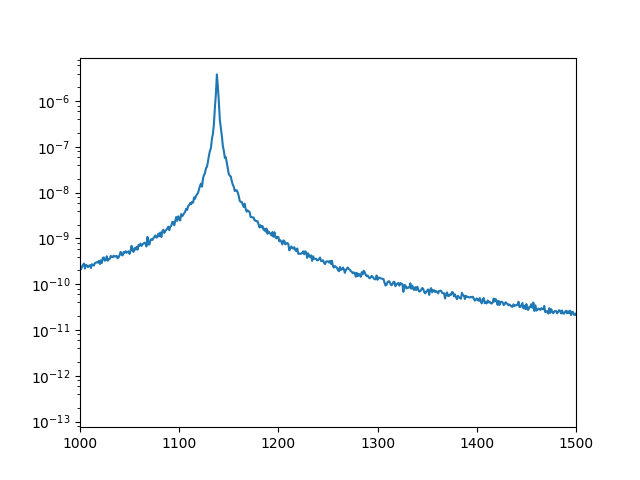

(1000, 1500)

In [99]:
plt.figure()
plt.semilogy(np.sum(np.abs(np.fft.fft(positions[:,:,2],axis=0))**2, axis=1))
plt.xlim(1000, 1500)

<IPython.core.display.Javascript object>


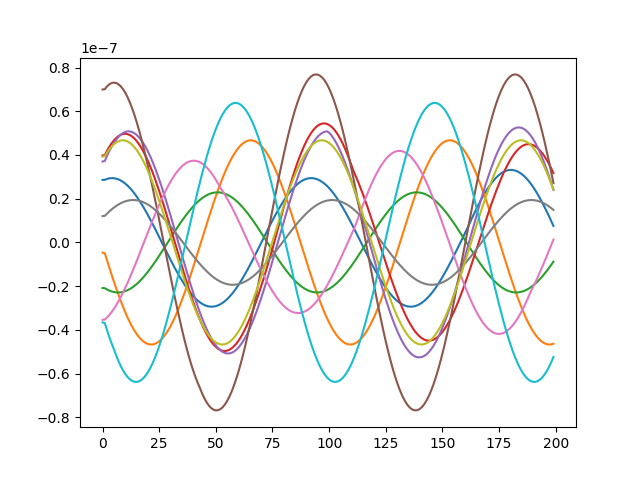

In [89]:
plt.figure()
for i in range(10):
    plt.plot(positions[:200,i,2])